# Datos

In [1]:
# General Purpose
import pandas as pd
import matplotlib.pyplot as plt
import os

# Data access
from dataAccess import aws_df_from_S3_csv

# FE
from CustomTransform import DistanceEncoder, SizeMeanEncoder, RangeEncoder, CustomKNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

# Modelos
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost.sklearn import XGBModel as xgb

In [2]:
# Cargamos los datos
 
# dataTrain = awsFunctions.aws_df_from_S3_csv(file = "04-2021/datos-dep/depDataTrain_Arnau_20-08.csv", bucket = 'datos-viviendas')
dataTrain = pd.read_csv('depDataTrain_Arnau_20-08.csv')

# Modelado

In [3]:
target = 'ide_price'

y_train = dataTrain.pop(target)
X_train = dataTrain

### Transformers

In [4]:
# Distance Encoder:
distanceOrigin = [['sol', [40.414650, -3.700400]],
                  ['nmi', [40.446278, -3.691814]],
                  ['pca', [40.466070, -3.689280]]]
distanceEncoderColumn = ['ide_latitude', 'ide_longitude']
distanceEncoder = list()
for i in range(3):
    distanceEncoder.append(
        DistanceEncoder('fe_distance_' + distanceOrigin[i][0], distanceEncoderColumn, distanceOrigin[i][1]))

# Size Mean Encoder:
sizeMeanEncoderColumn = 'ide_size'
sizeMeanGroup = ['barrio', 'distrito']
sizeMeanEncoders = list()
for i in range(2):
    sizeMeanEncoders.append(
        SizeMeanEncoder('fe_mean_size_' + sizeMeanGroup[i], sizeMeanEncoderColumn, 'geo_' + sizeMeanGroup[i]))

# Range Enconders:
rangeEncoders = list()
rangeEncoders.append(RangeEncoder('fe_latitude_bins', 'ide_latitude', 10))
rangeEncoders.append(RangeEncoder('fe_longitude_bins', 'ide_longitude', 10))

# Custom KNNImputer
imputer = CustomKNNImputer(n_neighbors = 5, weights = 'distance')

# Column Transformer for OneHotEncoder
categorical_features = ['geo_distrito', 'geo_barrio', 'fe_latitude_bins', 'fe_longitude_bins']
oneHotColumnTransformer = ColumnTransformer([
    ("oneHotEncoder", OneHotEncoder(handle_unknown='ignore'),
     categorical_features)
], remainder = 'passthrough')

## Model Selection

In [5]:
""" Realizaremos un análisis de los siguientes modelos con las siguentes features """

seed = 42

models = []
models.append(('LR', LinearRegression()))
models.append(('Lasso', Lasso(alpha=0.1,random_state=seed)))
models.append(('DTR', DecisionTreeRegressor(random_state=seed)))
models.append(('KNR', KNeighborsRegressor()))
models.append(('RFR', RandomForestRegressor(random_state=seed, n_jobs = -1)))
models.append(('GBR', GradientBoostingRegressor(random_state=seed)))
models.append(('XGB', xgb(random_state=seed)))

# Ensamblado
reg1 = RandomForestRegressor(random_state=seed, n_jobs = -1)
reg2 = GradientBoostingRegressor(random_state=seed)
reg3 = KNeighborsRegressor()
models.append(('VR', VotingRegressor(estimators=[('rf', reg1), ('gb', reg2), ('kn', reg3)])))

In [6]:
metrics = []
metrics.append(('MAPE','neg_mean_absolute_percentage_error'))
metrics.append(('MAE','neg_mean_absolute_error'))
metrics.append(('MSE','neg_mean_absolute_percentage_error'))
metrics.append(('RMSE','neg_root_mean_squared_error'))
metrics.append(('R2','r2'))

In [7]:
""" Para plotear los resultados utilizaremos la siguiente función """

def boxplots_algorithms(results, names, metric):
    
    # Export images
    if not os.path.exists("boxplots"):
        os.mkdir("boxplots")
        
    plt.figure(figsize=(8,8))
    plt.boxplot(results)
    plt.xticks(range(1,len(names)+1), names)
    plt.title(metric)
    plt.savefig('boxplots/' + metric + '.jpg', transparent = True)
    plt.show() 

DTR: -0.219840 (0.004584)
KNR: -0.213647 (0.002972)
RFR: -0.169604 (0.001447)
GBR: -0.213156 (0.002225)
XGB: -0.184858 (0.001684)
VR: -0.180796 (0.000573)


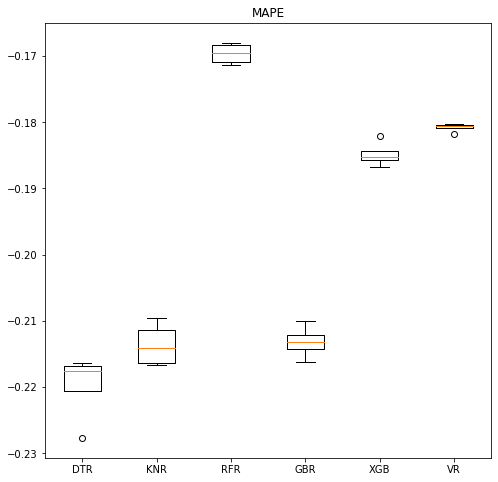

DTR: -0.219840 (0.004584)
KNR: -0.213647 (0.002972)
RFR: -0.169604 (0.001447)
GBR: -0.213156 (0.002225)
XGB: -0.184858 (0.001684)
VR: -0.180796 (0.000573)


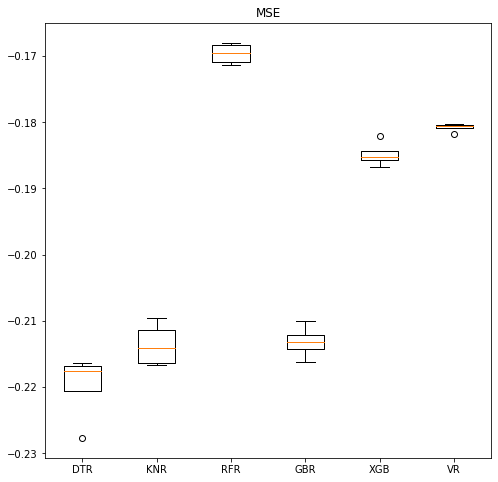

In [8]:
for metric, scoring in metrics:
    results = []
    names = []
    for name, model in models:

        pipeline = Pipeline([('Encoder1', distanceEncoder[0]),
                             ('Encoder2', distanceEncoder[1]),
                             ('Encoder3', distanceEncoder[2]),
                             ('Encoder4', sizeMeanEncoders[0]),
                             ('Encoder5', sizeMeanEncoders[1]),
                             ('Encoder6', rangeEncoders[0]),
                             ('Encoder7', rangeEncoders[1]),
                             ('Imputer1', imputer),
                             ('Encoder8', oneHotColumnTransformer),
                             ('scaler', RobustScaler(with_centering = False)), # False for sparse matrix
                             ('Model', model)])

        cv_technique = KFold(n_splits=4, shuffle=True, random_state=seed)
        cv_results = cross_val_score(pipeline,           # Pipeline
                                     X_train,           # Feature matrix
                                     y_train,             # Target vector
                                     cv=cv_technique,    # Cross-validation technique
                                     scoring=scoring, # scoring
                                     n_jobs = -1) 

        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)

        results.append(cv_results)
        names.append(name)

    boxplots_algorithms(results, names, metric)